  Running setup.py install for bz2file: started
    Running setup.py install for bz2file: finished with status 'done'


You are using pip version 18.1, however version 19.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [392]:
import torch
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, TensorDataset
from contextlib import contextmanager
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

cuda = torch.device("cuda")
cpu = torch.device("cpu")
dev = cuda if torch.cuda.is_available() else cpu

@contextmanager
def switch_to_cpu(model):
    global dev
    _dev = dev
    dev = cpu
    model.to(cpu)
    yield
    dev = _dev
    model.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def get_model():
    layer_size = 16
    return nn.Sequential(
        nn.Conv2d(1, layer_size, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(layer_size, layer_size, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(layer_size, 10, kernel_size=3, stride=2, padding=1),
        nn.AdaptiveAvgPool2d(1),
        Lambda(lambda x: x.view(x.size(0), -1)),
    )


def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), float(len(xb))

def predict_batch(model, data_loader):
    reals = []
    preds = []
    for xb, yb in data_loader:
        reals.append(yb)
        preds.append(model(xb).argmax(dim=1))
    
    return torch.cat(reals, 0), torch.cat(preds, 0)

def accuracy(model, data_loader):
    y_true, y_pred = predict_batch(model, data_loader)
    return torch.nonzero(y_true == y_pred).size(0) / y_pred.size(0)

def loss(model, loss_func, data_loader):
    losses = []
    nums = []
    for xb, yb in data_loader:
        l, n = loss_batch(model, loss_func, xb, yb)
        losses.append(l)
        nums.append(n)
    nums = torch.tensor(nums)
    return (torch.tensor(losses).mul(nums).sum() / nums.sum()).item()

def fit(model, loss_func, opt, train_dl, *, valid_dl=None, max_epochs=20, threshold=1e-6, min_epochs=None, silent=False):
    validation = valid_dl is not None
    print("Fitting a model...")
    last_loss = float("inf")
    epoch = 1
    accuracies = []
    losses = []
    while True:
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        model.eval()
        
        with torch.no_grad():
            # print diagnostics about current epoch
            if validation:
                val_loss = loss(model, loss_func, valid_dl)
                val_acc = accuracy(model, valid_dl)
            train_loss = loss(model, loss_func, train_dl)
            train_acc = accuracy(model, train_dl)
        if not silent:
            if validation:
                print("Epoch %s: val_loss=%s, train_loss=%s, val_acc=%s, train_acc=%s" % (epoch, val_loss, train_loss, val_acc, train_acc))
            else:
                print("Epoch %s: train_loss=%s, train_acc=%s" % (epoch, train_loss, train_acc))
        
        losses.append((val_loss, train_loss) if validation else train_loss)
        accuracies.append((val_acc, train_acc) if validation else train_acc)
        
        compare_loss = (val_loss if validation else train_loss)
        min_epochs_satisified = min_epochs is None or epoch >= min_epochs
        
        # stop execution
        if threshold and last_loss - compare_loss < threshold and min_epochs_satisified:
            print("delta loss %s was lower than threshold %s, stopping" % (last_loss - compare_loss, threshold))
            break
        
        if max_epochs is not None and epoch >= max_epochs and min_epochs_satisified:
            print("Max epochs reached, stopping")
            break
        last_loss = compare_loss
        epoch += 1
    return np.array([losses, accuracies])


def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

def get_dl(xs, ys, prep=preprocess, bs=30):
    return WrappedDataLoader(DataLoader(TensorDataset(xs.type(torch.float32) / 255, ys), batch_size=bs), prep)

def get_dls(xs, ys, prep=preprocess, bs=30):
    n = len(ys) // 5
    return {'valid': get_dl(xs[:n], ys[:n], prep, bs), 'train': get_dl(xs[n:], ys[n:], prep, bs)}
        


In [393]:
torch.manual_seed(213742069)
torch.cuda.manual_seed_all(213742069)
torch.cuda.manual_seed(213742069)
train = FashionMNIST('.', download=True, train=True)
first_model = get_model()
first_model.to(dev)
dls = get_dls(train.train_data, train.train_labels, bs=30)
results = fit(first_model, F.cross_entropy, torch.optim.Adam(first_model.parameters()), dls['train'], valid_dl=dls['valid'], min_epochs=50, max_epochs=50)

print("DONE!")


Fitting a model...
Epoch 1: val_loss=0.8929525017738342, train_loss=0.8885587453842163, val_acc=0.6833333333333333, train_acc=0.6816458333333333
Epoch 2: val_loss=0.7439614534378052, train_loss=0.7431035041809082, val_acc=0.7401666666666666, train_acc=0.7384791666666667
Epoch 3: val_loss=0.6718599200248718, train_loss=0.6704334020614624, val_acc=0.7733333333333333, train_acc=0.7682291666666666
Epoch 4: val_loss=0.6286476850509644, train_loss=0.6258839964866638, val_acc=0.7901666666666667, train_acc=0.7848125
Epoch 5: val_loss=0.5953837037086487, train_loss=0.5911961793899536, val_acc=0.8, train_acc=0.7975833333333333
Epoch 6: val_loss=0.5701106786727905, train_loss=0.5645646452903748, val_acc=0.8073333333333333, train_acc=0.8070416666666667
Epoch 7: val_loss=0.5507367849349976, train_loss=0.5436904430389404, val_acc=0.8136666666666666, train_acc=0.8131041666666666
Epoch 8: val_loss=0.5353536605834961, train_loss=0.5271668434143066, val_acc=0.8185, train_acc=0.8174791666666666
Epoch 9: 

In [350]:
xs, ys = train.train_data, train.train_labels
DataLoader(TensorDataset(xs.type(torch.float32), ys), batch_size=30).__dict__.items()


dict_items([('dataset', <torchsample.datasets.TensorDataset object at 0x000002AC6CF67208>), ('batch_size', 30), ('num_workers', 0), ('collate_fn', <function default_collate at 0x000002AC15CF9EA0>), ('pin_memory', False), ('drop_last', False), ('timeout', 0), ('worker_init_fn', None), ('sampler', <torch.utils.data.sampler.SequentialSampler object at 0x000002AC6CF67828>), ('batch_sampler', <torch.utils.data.sampler.BatchSampler object at 0x000002AC6CF678D0>), ('_DataLoader__initialized', True)])

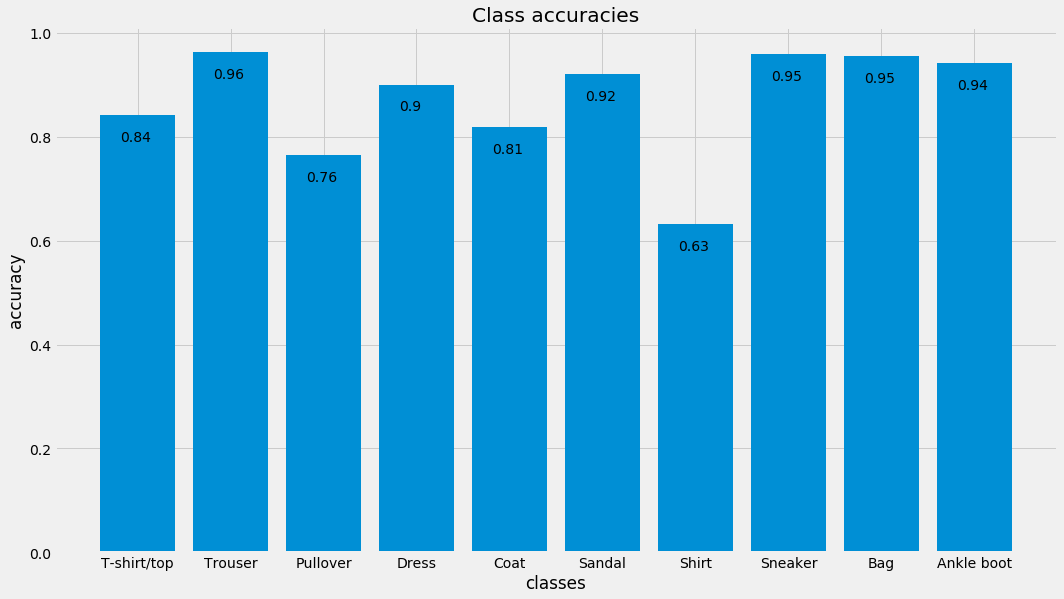

In [399]:
acc = []

for y, xs in enumerate(categorized):
    n = len(xs)
    ys = y * torch.ones(n, dtype=torch.long)
#     xs = next(iter(get_dl(torch.from_numpy(xs), ys, preprocess, n)))[0]
    acc.append(accuracy(first_model, get_dl(torch.from_numpy(xs), ys, preprocess, n)))

plt.figure(figsize=(16, 9))
plt.bar(str_labels, acc)
for i, v in enumerate(acc):
    plt.text(i - 0.19,  v - 0.05,  v * 100 // 1 / 100)
plt.xlabel('classes')
plt.ylabel('accuracy')
plt.title('Class accuracies')
plt.show()

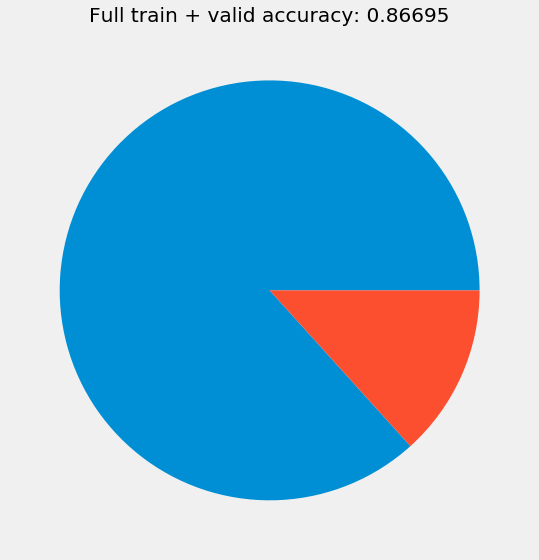

In [309]:
with switch_to_cpu(first_model):
    preds = first_model(next(iter(get_dl(train.train_data, train.train_labels, preprocess, 10000000)))[0]).argmax(dim=1)
    acc = accuracy_score(train.train_labels, preds)
plt.figure(figsize=(16, 9))
plt.pie([acc, 1 - acc])
plt.title("Full train + valid accuracy: %s" % acc) 
plt.show()

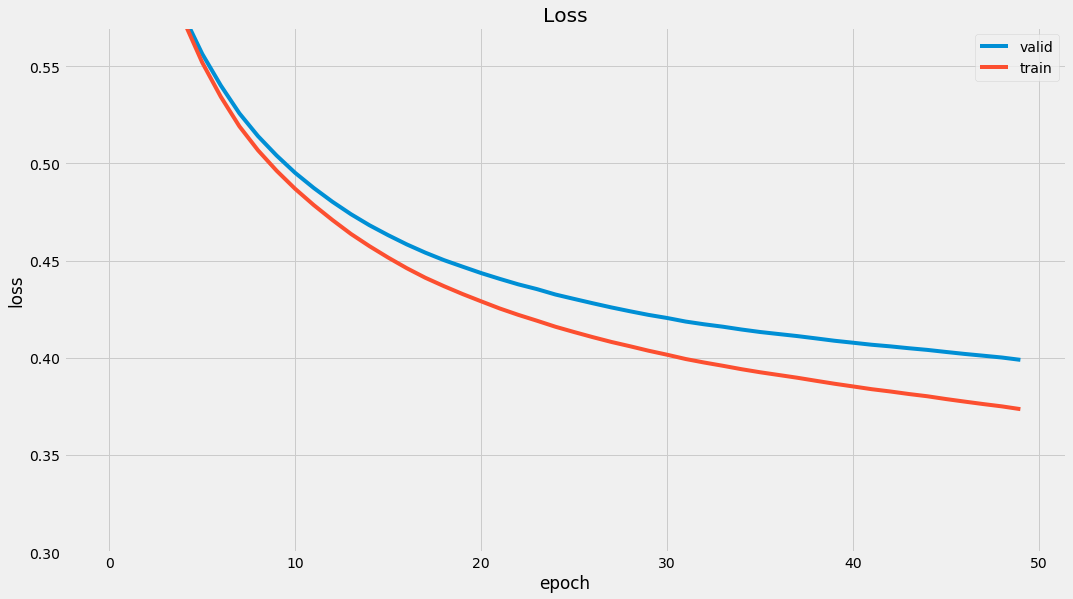

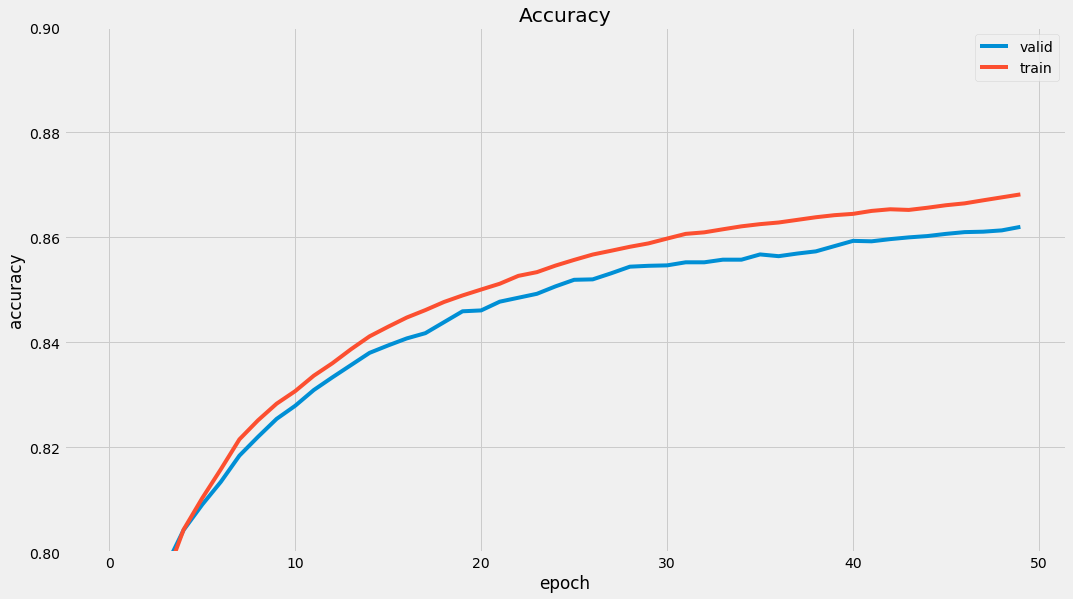

In [310]:
for i, (title, ylimits) in enumerate(zip(['Loss', 'Accuracy'], [(0.3, 0.57), (0.80, 0.9)])):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(16, 9))
    plt.plot(results[i, :, 0], label='valid')
    plt.plot(results[i, :, 1], label='train')
    plt.ylim(*ylimits)
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(title.lower())
    plt.legend()
    plt.show()

In [371]:
x = train.train_data[0]
x

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [279]:

test = FashionMNIST('.', download=True, train=False)
test_dl = get_dl(test.test_data, torch.ones(test.test_data.size(0)), 10000)
preds = model(next(iter(test_dl))[0])
preds = preds.argmax(dim=1)
import pandas as pd
df = pd.DataFrame()
df['Class'] = preds
df.index.name = 'Id'
df.to_csv('submission.csv')
df